In [58]:
# # Run the code below for setting up google colab enviroment
# # install condacolab
# !pip install -q condacolab
# import condacolab
# condacolab.install()

# # copy from github
# !git clone https://github.com/valence-labs/mtl_summer_school_2024.git

# # change working directory
# import os
# os.chdir("mtl_summer_school_2024/Lab1")

# # install dependencies
# !mamba env update -n base -f env.yml

# ML in drug discovery programs
To successfully apply ML, we need 
- a data set of molecules and bioactivities, 
- a molecular representation,
- a ML algorithm to train a model and 
- appropriate evaluation strategy which suits project objectives. 

Then, we can make predictions for new molecules.

## Leveraging public data

The popular public databases for chemicals and bioactivities:

- Pubchem: 118M Compounds for 295M Bioactivities
- ChEMBL:  2.43M Compounds for 20.7M Bioactivities
- Others: BindingDB, KLIFS, clue.io L1000, etc.

- Get the right data for your problem that ML can help to solve. 
- Try denoise your data from chemical structures, bioactivities.
- Not all the datasets can be combined. 

**Readouts for EGFR inhibition**: 
- %inhibition at different concentrations (uM, nM)
- IC50:  Inhibitory concentration 50%

<img src="figures/IC50_determination_illustration.png" width="500"/>

- $pIC_{50} = -log_{10}(IC_{50})$
  
- Inhibition constant (Ki), Dissociation constant (Kd)

### Load compound and activity data

Let’s start by loading our data. The csv file is loaded into a dataframe with the important columns:

- `MOL_smiles`: SMILES string of the corresponding compound.

- `pIC50`: Measured inhibition.

In [3]:
import pandas as pd
import datamol as dm
import numpy as np

# load pre-processed data
data = pd.read_csv("data/egfr_pIC50_tutorial.csv")
mol_col = "MOL_smiles"
data_col = "pIC50"

In [4]:
# Look at head
print("Shape of dataframe : ", data.shape)
data.head()

Shape of dataframe :  (4396, 4)


,MOL_smiles,pIC50,Gene_Symbol,Original_Entry_ID
0,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...,6.73,EGFR,CHEMBL175513
1,O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21,6.80,EGFR,CHEMBL268868
2,CC(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc5sncc45)c(Cl...,8.54,EGFR,CHEMBL2048906
3,CCOc1ccc(-c2nn(C3CCCC3)c3ncnc(N)c23)cc1OC,5.85,EGFR,CHEMBL1240554
4,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,9.70,EGFR,CHEMBL553


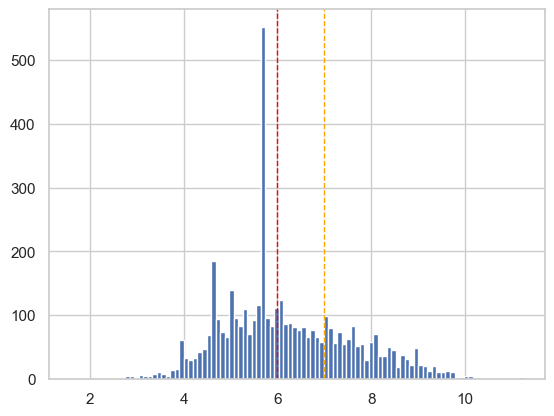

In [59]:
fig = data[data_col].hist(bins=100)
fig.axvline(6, color='red', linestyle='dashed', linewidth=1)
fig.axvline(7, color='orange', linestyle='dashed', linewidth=1)

### Distribution in the chemical space
The screening library covers the dataset within the chemical space.

<img src="figures/chemspace.png" width="800"/>

In [6]:
# add inter similarity and intra similarity 

## For ML, molecules need to be converted into features/representation.

In this tutorial, we will focus on **Fingerprint** and **Molecular Graph**.

### Morgan fingerprints ECFP
Extended-Connectivity Fingerprints (ECFPs) are circular topological fingerprints designed for molecular characterization, similarity searching, and structure-activity modeling. We use the implementation from RDKit which is called Morgan fingerprint.

The two most important parameters of these fingerprints are the `radius` and `fingerprint length`. The first specifies the radius of circular neighborhoods considered for each atom. Here two radis are considered: 2 and 3. The length parameter specifies the length to which the bit string representation is hashed. The default length is 2048.


<img src="figures/ecfp_generation.png" width="800"/>

<img src="figures/ecfp_folding.png" width="800"/>

This implementation is avalaible in [molfeat](https://molfeat.datamol.io/), which is a hub for all molecular featurizers.

In [64]:
from molfeat.trans.fp import FPVecTransformer

fp_transformer = FPVecTransformer(kind='ecfp:4', length=2048)
features = fp_transformer(data[mol_col].values)

# or use `datamol.to_fp`
# features = np.stack(dm.parallelized(fn=dm.to_fp, inputs_list=egfr[mol_col].values, progress=True))

features.shape

(4396, 2048)

In [66]:
# get the inhibition
activities = data[data_col].values
activities

array([6.73, 6.8 , 8.54, ..., 6.21, 6.25, 5.8 ])

Use those molecular fingerprints as features as the inputs for ML model.

<img src="figures/fp_ml.png" width="300"/>

In [8]:
# Exercise 1: Custom featurization
# How to best featurize a molecule depends on the task you're trying to solve. 
# In this example, we used ECFP. Datamol.io `molfeat` offers a range of other featurization schemes that
# may perform better. Try out a few different options by overwriting the features variable.

# === YOUR CODE GOES HERE ===
# fp_transformer = 
# features =

# === END ===

###  Molecular graph

<img src="figures/graph.png" width="500"/>

In [9]:
### Process smiles into `torch_geometric.Data` objects
from molfeat.trans.graph.adj import PYGGraphTransformer

# convert smiles to Rdkit.Mol object
mols = dm.parallelized(fn=dm.to_mol, inputs_list=data[mol_col], progress=True)

# convert Rdkit.Mol object to `torch_geometric.Data` object
transformer = PYGGraphTransformer()
pyg_features = transformer(mols)

  0%|          | 0/4396 [00:00<?, ?it/s]

In [10]:
#### Example of a molecular graph object
pyg_mol = pyg_features[0]
pyg_mol

Data(x=[43, 82], edge_index=[2, 94])

In [11]:
# Visualize the adjacent matrix of the above graph object
from torch_geometric.utils import to_dense_adj

to_dense_adj(pyg_mol.edge_index)

tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]]])

=> We can use pyg graph object as input for GNN modeling for inhibition prediction.

## Model training

The goal is to test the ability of the model to predict data which it has never seen before in order to flag problems known as over fitting and to assess the generalization ability of the model.

We start by defining a function model_performance which evaluate a model on a **random train-test split** of the data and returns measures such as `mean_squared_error`, `pearsonr`and `spearmanr` evaluated on the heldout test set. We also plot the scatter plot of the true bioactivity and predictions with a linear regression model fit.

In [12]:
from sklearn.metrics import mean_squared_error, precision_recall_fscore_support
from scipy import stats
import torch
from loguru import logger
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

In [13]:
# Utility functions 

# Metrics
def pearsonr(y_true: np.ndarray, y_pred: np.ndarray):
    """Calculate a pearson r correlation"""
    return stats.pearsonr(y_true, y_pred).statistic


def spearman(y_true: np.ndarray, y_pred: np.ndarray):
    """Calculate a Spearman correlation"""
    return stats.spearmanr(y_true, y_pred).statistic


def model_performance(ml_model, test_x, test_y, threshold=6, verbose=True):
    """
    Helper function to calculate model performance

    Args
    ----------
    ml_model: model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        MSE, Pearson R, Spearman on test set.
    """

    # Prediction class on test 
    if isinstance(ml_model, RandomForestRegressor):
        test_pred = ml_model.predict(test_x)
    else:
        ml_model.eval() #set model to evaluate mode
        test_pred = torch.cat([ml_model.predict(x) for x in test_x]).numpy().flatten()

    # Performance of model on test set
    ## regression
    mse = mean_squared_error(test_y, test_pred)
    pearsonr_score = pearsonr(test_y, test_pred)
    spearman_score = spearman(test_y, test_pred)
    ## classification
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true=test_y > threshold, y_pred=test_pred > threshold ,average="binary")

    if verbose:
        # Print performance results
        logger.info(f"mean_squared_error: {mse:.2f}")
        logger.info(f"pearson r: {pearsonr_score:.2f}")
        logger.info(f"spearman: {spearman_score:.2f}")
        logger.info(f"precision: {precision:.2f}")
        logger.info(f"recall: {recall:.2f}")
        logger.info(f"fscore: {fscore:.2f}")

    plot_df = pd.DataFrame({"y_true": test_y, "y_pred": test_pred})
    sns.set_style("whitegrid")
    fig = sns.regplot(data=plot_df, x="y_true", y="y_pred")
    fig.axvline(threshold, color='orange', linestyle='dashed', linewidth=1)
    fig.axhline(threshold, color='orange', linestyle='dashed', linewidth=1)
    
    return mse, pearsonr_score, spearman_score, precision, recall, fscore, fig


#### Data splitting for hit identification

<img src="figures/chemspace.png" width="800"/>

Let's create split data into train and test set. The splits will be shared with all the models. 

**Scaffold splitting** is approach that identifies chemical series or scaffolds in the dataset and moving all molecules sharing one or more scaffolds to the test set. \
The **goal** is to evaluate how well a model performs on scaffolds and regions of chemical space that differ from those it was trained on. 

In [67]:
from splito._scaffold_split import get_scaffold

# compute Murcko scaffolds
scaffolds = dm.utils.parallelized(fn=get_scaffold, inputs_list=data[mol_col].tolist(), n_jobs=-1, progress=True)
print(f"There are unique {len(set(scaffolds))} scaffolds for {len(data)} molecules in the dataset.")

  0%|          | 0/4396 [00:00<?, ?it/s]

There are unique 1777 scaffolds for 4396 molecules in the dataset.


Training data size: 3355
Test data size: 1041


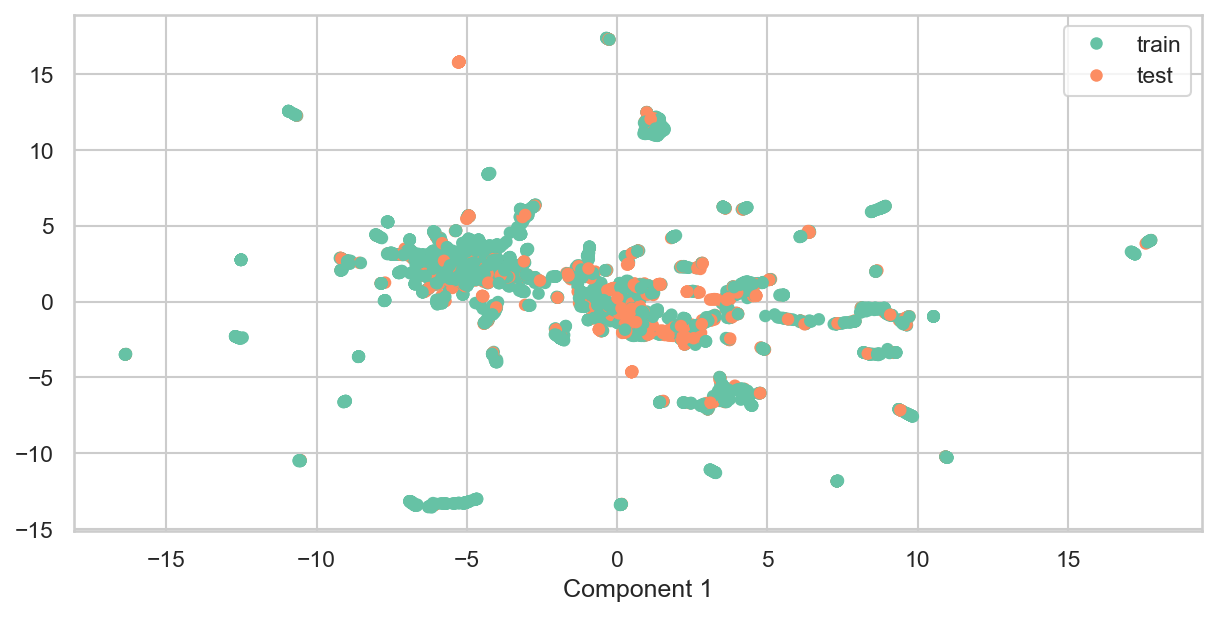

In [68]:
from splito._scaffold_split import ScaffoldSplit

spliter = ScaffoldSplit(smiles=data[mol_col].values, n_splits=5, test_size=.2, random_state=111)
train_index, test_index = next(spliter.split(activities))

print("Training data size:", len(train_index))
print("Test data size:", len(test_index))

from chemspace_viz import visualize_chemspace
split_labels = np.full(len(features), "train", dtype=object)
split_labels[test_index] = "test"
fig = visualize_chemspace(X=features, y=[split_labels])

In [16]:
# Exercise 2: Choice of splitting method
# We have 
# In this example, we used scaffold based spliting approach. Datamol.io `splito` offers a range of other splitting method schemes that
# may suit the project purpose better. Try out a few different splitting method and observe the impact on model performance.
# Checkout `splito.simpd.SIMPDSpliter`.

# === YOUR CODE GOES HERE ===
# spliter = 
#
# === END ===

#### Random forest regressor

In [17]:
# Get the features and bioactivities of the training set
train_x, train_y = features[train_index], activities[train_index]

print("Training set data shape:", train_x.shape)

Training set data shape: (3355, 2048)


In [18]:
# Define a model and train
from sklearn.ensemble import RandomForestRegressor

# Set model parameter for random forest
rf_param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "squared_error",  # cost function to be optimized for a split
}

RF_model = RandomForestRegressor(**rf_param)

In [19]:
# Fit model on single train split
RF_model.fit(train_x, train_y)

RandomForestRegressor()

2024-06-11 00:27:22.006 | INFO     | __main__:model_performance:52 - mean_squared_error: 0.99
2024-06-11 00:27:22.006 | INFO     | __main__:model_performance:53 - pearson r: 0.76
2024-06-11 00:27:22.006 | INFO     | __main__:model_performance:54 - spearman: 0.77
2024-06-11 00:27:22.007 | INFO     | __main__:model_performance:55 - precision: 0.81
2024-06-11 00:27:22.007 | INFO     | __main__:model_performance:56 - recall: 0.88
2024-06-11 00:27:22.007 | INFO     | __main__:model_performance:57 - fscore: 0.85


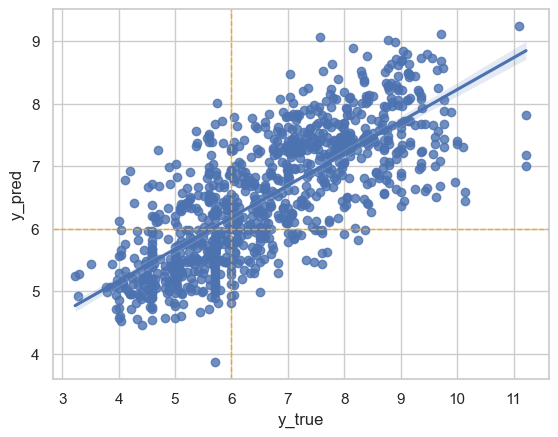

In [20]:
# Get the features and bioactivities of the test set
test_x, test_y = features[test_index], activities[test_index]

# Compute the performance and generate the plot
res = model_performance(RF_model, test_x, test_y, verbose=True, threshold=6)

In [21]:
# Dump the transformer and model to pickle file
import pickle

with open("model/rf_regressor.pkl", "wb") as fout:
    pickle.dump((fp_transformer, RF_model), fout)

#### Cross validation scaffold split.
<img src="figures/sphx_glr_plot_cv_indices_011.png" width="500"/>



In [22]:
# define cross validation process and metrics

from sklearn import clone

def cross_validation(ml_model, spliter, features, activities, verbose=True, threshold=6):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    # Results for each of the cross-validation folds
    pearsonr_per_fold = []
    spearman_per_fold = []
    mse_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    fscore_per_fold = []

    # Loop over the folds
    for train_index, test_index in spliter.split(features):

        # clone the newly initiated model
        fold_model = clone(ml_model)
        
        # Training

        # Convert the fingerprint and the label to a list
        train_x = features[train_index]
        train_y = activities[train_index]

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = features[test_index]
        test_y = activities[test_index]

        # Performance for each fold
        mse, pearsonr_score, spearman_score, precision, recall, fscore, _ = model_performance(ml_model=fold_model, test_x=test_x, test_y=test_y, 
                                                                                              verbose=verbose, threshold=threshold)

        # Save results
        mse_per_fold.append(mse)
        pearsonr_per_fold.append(pearsonr_score)
        spearman_per_fold.append(spearman_score)
        precision_per_fold.append(precision)
        recall_per_fold.append(recall)
        fscore_per_fold.append(fscore)

        
    # Print statistics of results
    print(
        f"Mean mean squared error: {np.mean(mse_per_fold):.2f} \t"
        f"and std : {np.std(mse_per_fold):.2f} \n"
        f"Mean pearsonr: {np.mean(pearsonr_per_fold):.2f} \t"
        f"and std : {np.std(pearsonr_per_fold):.2f} \n"
        f"Mean spearman: {np.mean(spearman_per_fold):.2f} \t"
        f"and std : {np.std(spearman_per_fold):.2f} \n"
        f"Mean precision: {np.mean(precision_per_fold):.2f} \t"
        f"and std : {np.std(precision_per_fold):.2f} \n"
        f"Mean recall: {np.mean(recall_per_fold):.2f} \t"
        f"and std : {np.std(recall_per_fold):.2f} \n"
        f"Mean fscore: {np.mean(fscore_per_fold):.2f} \t"
        f"and std : {np.std(fscore_per_fold):.2f} \n"
    )


2024-06-11 00:28:02.231 | INFO     | __main__:model_performance:52 - mean_squared_error: 1.01
2024-06-11 00:28:02.232 | INFO     | __main__:model_performance:53 - pearson r: 0.76
2024-06-11 00:28:02.232 | INFO     | __main__:model_performance:54 - spearman: 0.77
2024-06-11 00:28:02.233 | INFO     | __main__:model_performance:55 - precision: 0.80
2024-06-11 00:28:02.233 | INFO     | __main__:model_performance:56 - recall: 0.89
2024-06-11 00:28:02.233 | INFO     | __main__:model_performance:57 - fscore: 0.85
2024-06-11 00:28:21.117 | INFO     | __main__:model_performance:52 - mean_squared_error: 0.92
2024-06-11 00:28:21.118 | INFO     | __main__:model_performance:53 - pearson r: 0.72
2024-06-11 00:28:21.118 | INFO     | __main__:model_performance:54 - spearman: 0.73
2024-06-11 00:28:21.118 | INFO     | __main__:model_performance:55 - precision: 0.84
2024-06-11 00:28:21.119 | INFO     | __main__:model_performance:56 - recall: 0.84
2024-06-11 00:28:21.119 | INFO     | __main__:model_perfor

Mean mean squared error: 0.86 	and std : 0.11 
Mean pearsonr: 0.74 	and std : 0.02 
Mean spearman: 0.73 	and std : 0.03 
Mean precision: 0.80 	and std : 0.03 
Mean recall: 0.82 	and std : 0.06 
Mean fscore: 0.81 	and std : 0.04 



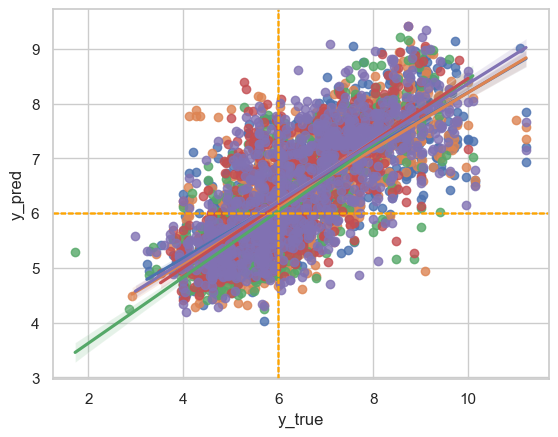

In [24]:
spliter = ScaffoldSplit(smiles=data[mol_col].values, n_splits=5, test_size=.2, random_state=111)
cross_validation(ml_model=RandomForestRegressor(**rf_param), spliter=spliter,
                 features=features, activities=activities, threshold=6)

#### Graph neural network
Here we try to train a graph neural network model with 3 convolutional layers and a followed by a linear transformer for final output.

In [25]:
import torch
from gnn import GCNModel

# Define the graph model
# Use CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# Create network and send to the device memory
gnn_model = GCNModel(in_channels=transformer(mols[0])[0].x.shape[1], 
                     hidden_channels=128, 
                     out_channels=1, 
                     num_layers=3,
                     is_reg=True).to(device)

# Use Adam optimizer
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001, weight_decay=1e-4) 


# Define the loss function
loss_fn = torch.nn.MSELoss()

In [26]:
# Display the GNN model
gnn_model

GCNModel(
  (conv_layers): ModuleList(
    (0): GCNConv(82, 128)
    (1-3): 3 x GCNConv(128, 128)
  )
  (out): Linear(in_features=256, out_features=1, bias=True)
)

Below we convert the smiles to pyg graph object directly using `PYGGraphTransformer` from `molfeat`.

Each graph in our dataset is encapsulated in a PyG Data object, a convient way of representing all structured data for use in Geometric Deep Learning (including graphs, point clouds, and meshes).

In [27]:
from molfeat.trans.graph.adj import PYGGraphTransformer

# convert smiles to Rdkit.Mol object
mols = np.array(dm.parallelized(fn=dm.to_mol, inputs_list=data[mol_col], progress=True))

# converT Rdkit.Mol object to `torch_geometric.Data` object
transformer = PYGGraphTransformer()

train_set = []
for index in train_index:
    pyg_data = transformer(mols[index])[0]
    pyg_data.y =torch.from_numpy(np.array([activities[index]])).to(torch.float32)
    train_set.append(pyg_data)

test_set = []
for index in test_index:
    pyg_data = transformer(mols[index])[0]
    pyg_data.y =torch.from_numpy(np.array([activities[index]])).to(torch.float32)
    test_set.append(pyg_data)

  0%|          | 0/4396 [00:00<?, ?it/s]

Batching graphs can often be a tedious and intricate process. Fortunately, PyG simplifies this task significantly! With a list of Data objects, we can effortlessly batch them into a PyG Batch object and also unbatch them back into individual graphs. Moreover, for straightforward scenarios like ours, the PyG DataLoader object takes care of all the batching automatically.

In [28]:
# Create dataloaders with batch size 8
from torch_geometric.loader import DataLoader

batch_size = 16

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [29]:
from tqdm import tqdm
num_epoch = 10

#train model
#set model to training mode
gnn_model.train() 

#run for epochs of training
for epoch in range(num_epoch): 
    sum_loss = 0 #used to compute average loss in an epoch

    #go over each training batches
    for batch in tqdm(train_loader): 
        batch = batch.to(device) #send data to device
        optimizer.zero_grad() #zero gradients
        
        # #evaluate data point
        out = gnn_model(batch)
        loss = loss_fn(out, batch.y) #compute the loss
        sum_loss += float(loss) # Add loss value to aggregate loss
        
        #compute gradients
        loss.backward()
        #apply optimization
        
        optimizer.step()
    logger.info('Epoch: {:03d}, Average loss: {:.5f}'.format(epoch, sum_loss/len(train_set)))


  0%|          | 0/210 [00:00<?, ?it/s]/Users/lu.zhu/miniconda3/envs/auroris/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 93%|█████████▎| 195/210 [00:00<00:00, 216.33it/s]/Users/lu.zhu/miniconda3/envs/auroris/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 210/210 [00:01<00:00, 207.84it/s]
2024-06-11 00:29:48.450 | INFO     | __main__:<module>:27 - Epoch: 000, Average loss: 0.15308
100%|██████████| 210/2

2024-06-11 00:29:57.807 | INFO     | __main__:model_performance:52 - mean_squared_error: 2.35
2024-06-11 00:29:57.807 | INFO     | __main__:model_performance:53 - pearson r: 0.06
2024-06-11 00:29:57.808 | INFO     | __main__:model_performance:54 - spearman: 0.09
2024-06-11 00:29:57.808 | INFO     | __main__:model_performance:55 - precision: 0.57
2024-06-11 00:29:57.809 | INFO     | __main__:model_performance:56 - recall: 1.00
2024-06-11 00:29:57.809 | INFO     | __main__:model_performance:57 - fscore: 0.72


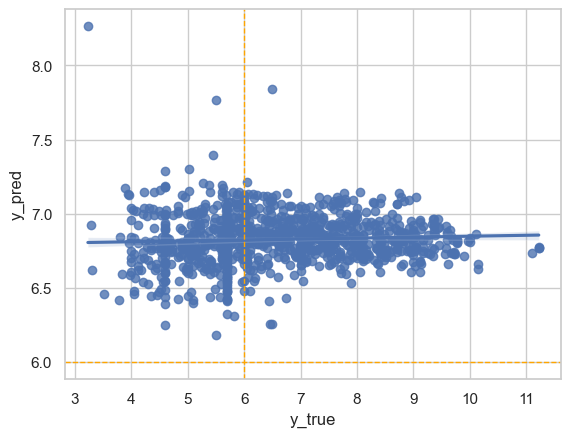

In [30]:
# Compute the performance and generate the plot

res = model_performance(gnn_model, test_loader, test_y, verbose=True, threshold=6)

#### Save both molecular transformer and the model 

In [31]:
import pickle
with open("model/gnn_regressor.pkl", "wb") as fout:
    pickle.dump((transformer, gnn_model), fout)

In [32]:
# Exercise 3: Graph representation learning with graphium

# Instead of `pyg`, try use Datamol.io `graphium` to train graph-based model. 
# Tutorials are available at https://graphium-docs.datamol.io

# === YOUR CODE GOES HERE ===
# gnn_config =
# gnn_model = 

# === END ===

#### Hyperparameter tuning

Hyperparameter tuning is the process of selecting the best set of parameters for a machine learning model and the dataset to improve the performance.

One can perform efficient HP tuning by using frameworks, such as **Optuna** and **Weights & Biases sweep**.

=> train/validation/test set

<img src="figures/HP_tuning.png" width="800"/>

# Virtual screening 

We have successfully trained several models. The next step is to use these models to predict binding affinity with an unknown screening dataset to discover novel potential EGFR inhibitors.

An example of a large screening dataset is MolPort, which contains over 7 million compounds. 

For demonstration purposes, we will perform virtual screening on a smaller library of 20,000 compounds specifically designed for discovering novel kinase ATP pocket binders.

In [33]:
import pickle
import numpy as np
import datamol as dm 

In [34]:
# load commercial screening library
lib_path = "data/Enamine_Hinge_Binders_Library_plated_24000cmds_20210316.sdf"
lib_df = dm.read_sdf(lib_path, as_df=True, mol_column="mol")

#### Check the library statistics

In [35]:
lib_df.describe()

,MW (desalted),CLogP,HBD,TPSA,RotBonds
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,348.377242,2.339357,1.406417,75.599830,4.600583
std,53.655375,1.339740,0.738477,19.544894,1.584347
min,177.226000,-2.841000,0.000000,19.370000,0.000000
25%,312.409000,1.418000,1.000000,61.880000,3.000000
50%,341.336000,2.370000,1.000000,74.610000,5.000000
75%,382.502250,3.250000,2.000000,87.910000,6.000000
max,544.355000,8.833000,5.000000,167.930000,15.000000


In [36]:
lib_df.head(5)

,smiles,mol,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds
0,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x2d7f40120>,Z57603637,1252574-R-230,A02,219.091,3.141,1,38.91,0
1,c1ccc(Nc2nccs2)nc1,<rdkit.Chem.rdchem.Mol object at 0x2d830e5e0>,Z57595474,1252574-R-135,E06,177.226,1.806,1,37.81,2
2,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x2d830e500>,Z56786333,1252574-R-162,E11,204.172,2.125,1,38.91,0
3,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x2d830d230>,Z48853893,1252574-R-230,C05,190.265,3.511,1,24.92,2
4,NC(=O)CSc1nc(N)nc(N)n1,<rdkit.Chem.rdchem.Mol object at 0x2d830c7b0>,Z17559442,1252574-R-156,B08,200.222,-1.545,3,133.80,3


#### Load the pre-trained models and transformers

In [37]:
# load the fingerprint transformer and random forest model for EGFR binding affinity
with open("model/rf_regressor.pkl", "rb") as f:
    fp_transformer, rf_model = pickle.load(f)

### Scoring the compounds in the library with the predictive models

Let's begin by defining a scoring function that converts the molecular SMILES to feature inputs for the predictive models and predicts their binding affinity to EGFR.

In [38]:
import torch 
from gnn import GCNModel

def score(mol, transformer, model, is_reg = True):
    try:
        # compute the molecular features
        feat = transformer(mol)
        if isinstance(model, GCNModel): # if 
            feat = transformer.get_collate_fn()(transformer(mol))[0]
        # score the molecule
        if is_reg:
            score = model.predict(feat)
        else:
            score = model.predict_proba(feat)[:, 1]
        if torch.is_tensor(score):
            score = score.flatten().numpy()
    except Exception as e:
        score = None
    return score

In [39]:
# Parallelize the scoring with 
lib_df["rf_preds_pIC50"] = dm.utils.parallelized_with_batches(fn=lambda mol: score(mol, fp_transformer, rf_model), inputs_list=lib_df.smiles.values, batch_size=1000, progress=True)

  0%|          | 0/24 [00:00<?, ?it/s]

## Compound prioritization

To define an active compound, an activity cut-off ranging from an pIC50 value of 5 to 7 in drug discovery programs. 

In this tutorial, we use a pIC50 value of 6 which is commonly used to define an active compound.



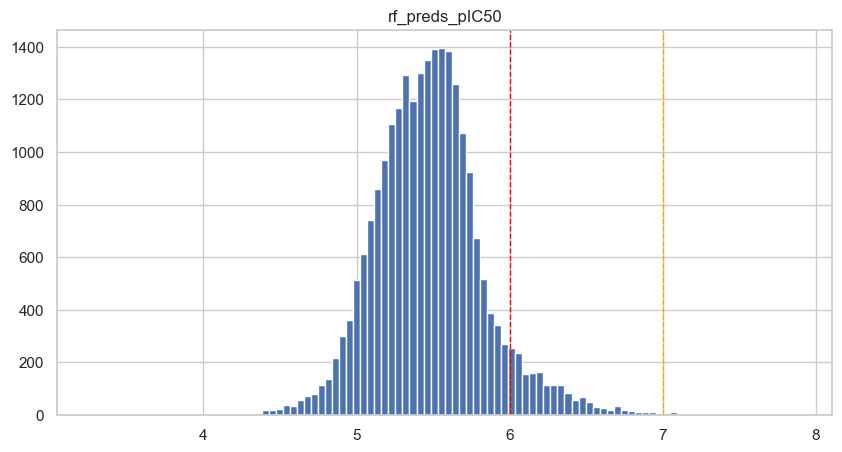

In [40]:
fig = lib_df[["rf_preds_pIC50"]].hist(bins=100, figsize=(10, 5))

for ax in fig[0]:
    ax.axvline(6, color='red', linestyle='dashed', linewidth=1,)
    ax.axvline(7, color='orange', linestyle='dashed', linewidth=1)

We have to make sure that non of the prioritiezed compounds are already in the training set. \
Therefore, we compare the `unique_id` of molecules, and exlude the repeated molecules from the prioritized set.

In [41]:
import pandas as pd

# Compute the unique id
data_train = pd.read_csv("data/egfr_pIC50.csv")
data_train["uid"] = data_train["MOL_smiles"].apply(lambda smi: dm.unique_id(dm.to_mol(smi)))

lib_df_gt_6 = lib_df.query("rf_preds_pIC50 > 6")
lib_df_gt_6["uid"] = lib_df_gt_6["mol"].apply(dm.unique_id).values

/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/ipykernel_60172/1542837347.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lib_df_gt_6["uid"] = lib_df_gt_6["mol"].apply(dm.unique_id).values


In [42]:
# Exclude the molecules in training set from the prioritized set
lib_df_gt_6 = lib_df_gt_6.query("uid not in @data_train.uid")
print("Number of compounds having predicted pIC50 greater than 6: ", lib_df_gt_6["rf_preds_pIC50"].gt(6).sum())
print("Number of compounds having predicted pIC50 greater than 7: ", lib_df_gt_6["rf_preds_pIC50"].gt(7).sum())

Number of compounds having predicted pIC50 greater than 6:  1702
Number of compounds having predicted pIC50 greater than 7:  32


In [73]:
lib_df_selected = lib_df_gt_6[lib_df_gt_6["MW (desalted)"].between(280, 400)]
len(lib_df_selected)

1354

In [44]:
# Exercise 4:  Multi-Objective Optimization

# This tutorial only uses the egfr binding affinity model for compound priotirization. 
# In real drug design programs, compounds often are optimized for multiple objectives.
# Please use toy model at `data/toy_classifier.pkl` as second objective (optimize for label 1) and rank the compounds. 
# You can use the ranking algorithm `MOORA` which is available at script `moora.py`.

# === YOUR CODE GOES HERE ===

# === END ===

### Distribution in chemical space
Now let's check the distribution of training set and screening set in chemical space.

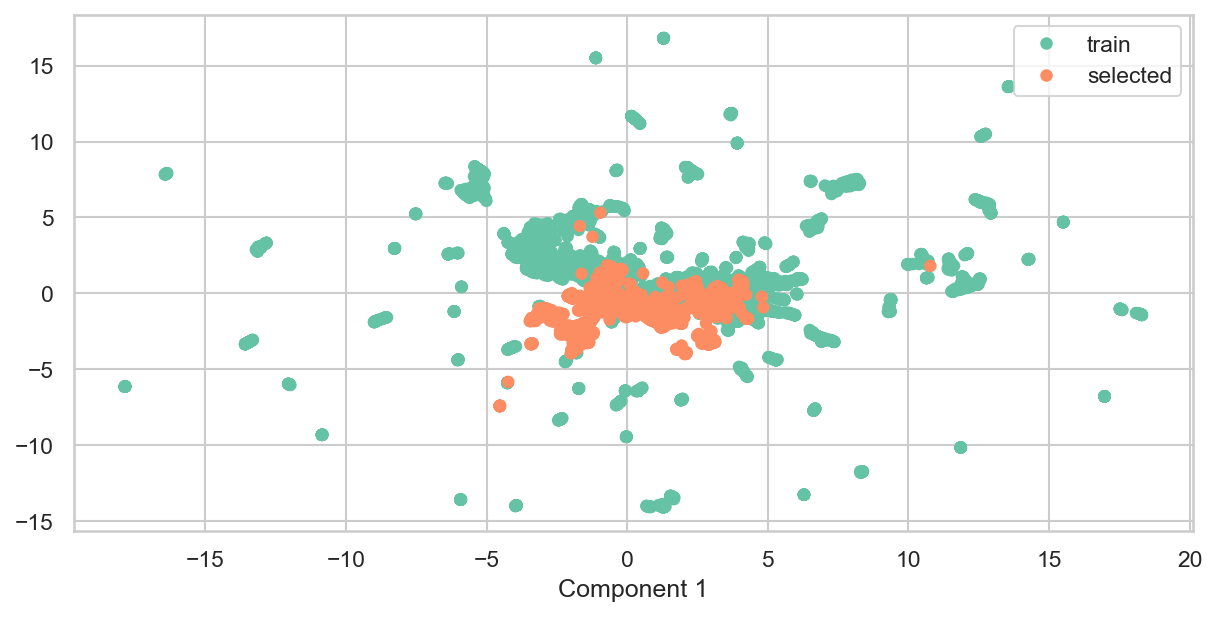

In [72]:
from chemspace_viz import visualize_chemspace

# compute the molecule features
train_feat = fp_transformer(data_train["MOL_smiles"])
lib_feat = fp_transformer(lib_df_selected["mol"])

fig = visualize_chemspace(X=np.concatenate([train_feat, lib_feat]), 
                          y=np.array(["train"] * len(train_feat) +["selected"] * len(lib_feat)))

The prioritized molecules (highlighted in orange) are mainly distributed in one cluster in the middle. Now we can use the predicted `pIC50` value to rank order the screened compounds and select a diverse set of these molecules for furture steps. 

#### Diverse pick of selected molecules
In drug discovery and development, selecting a diverse set of molecules is a critical step to ensure a comprehensive exploration of chemical space. This diversity maximizes the chances of identifying promising lead compounds with varying structural and functional characteristics. 

In [74]:
# Rank the molecules by pIC50
lib_df_gt_6_ranked = lib_df_selected.sort_values(by="rf_preds_pIC50", ascending=False).reset_index(drop=True)

In [75]:
# Select 100 most diverse molecules from the set
picked_index, _ = dm.pick_diverse(mols=lib_df_gt_6_ranked.mol.values, npick= 100, initial_picks=range(5) )
lib_df_picked = lib_df_gt_6_ranked.iloc[picked_index]

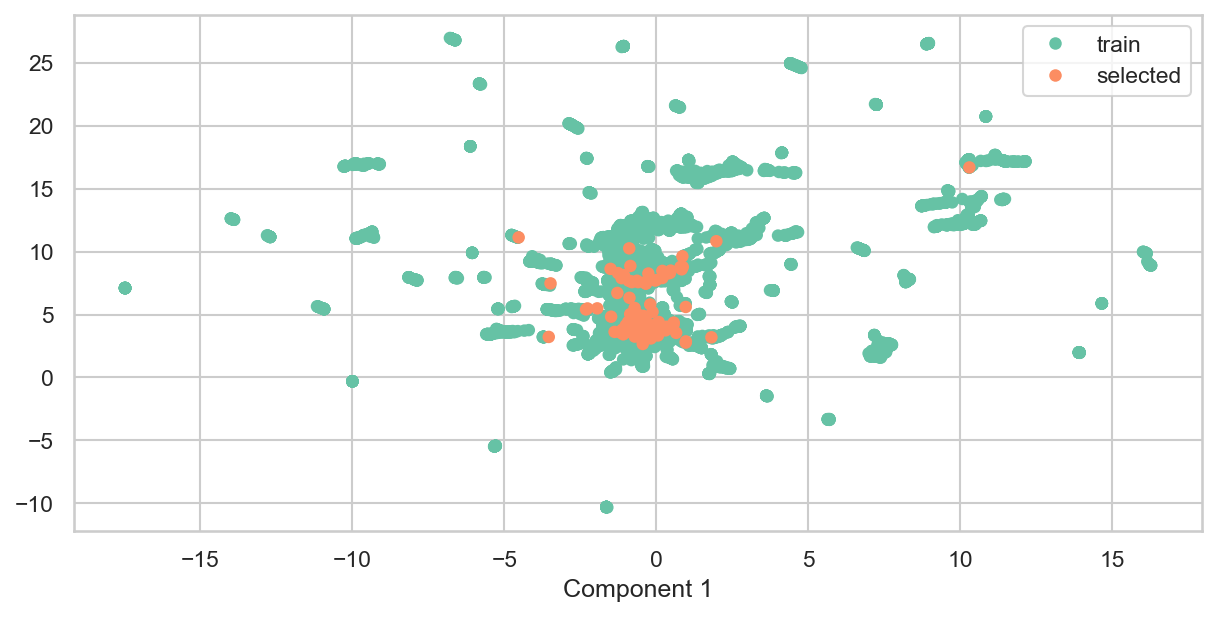

In [76]:
picked_feat = fp_transformer(lib_df_picked["mol"])
fig = visualize_chemspace(X=np.concatenate([train_feat, picked_feat]), 
                          y=np.array(["train"] * len(train_feat) +["selected"] * len(picked_feat)))

Now we visualize the picked molecules.

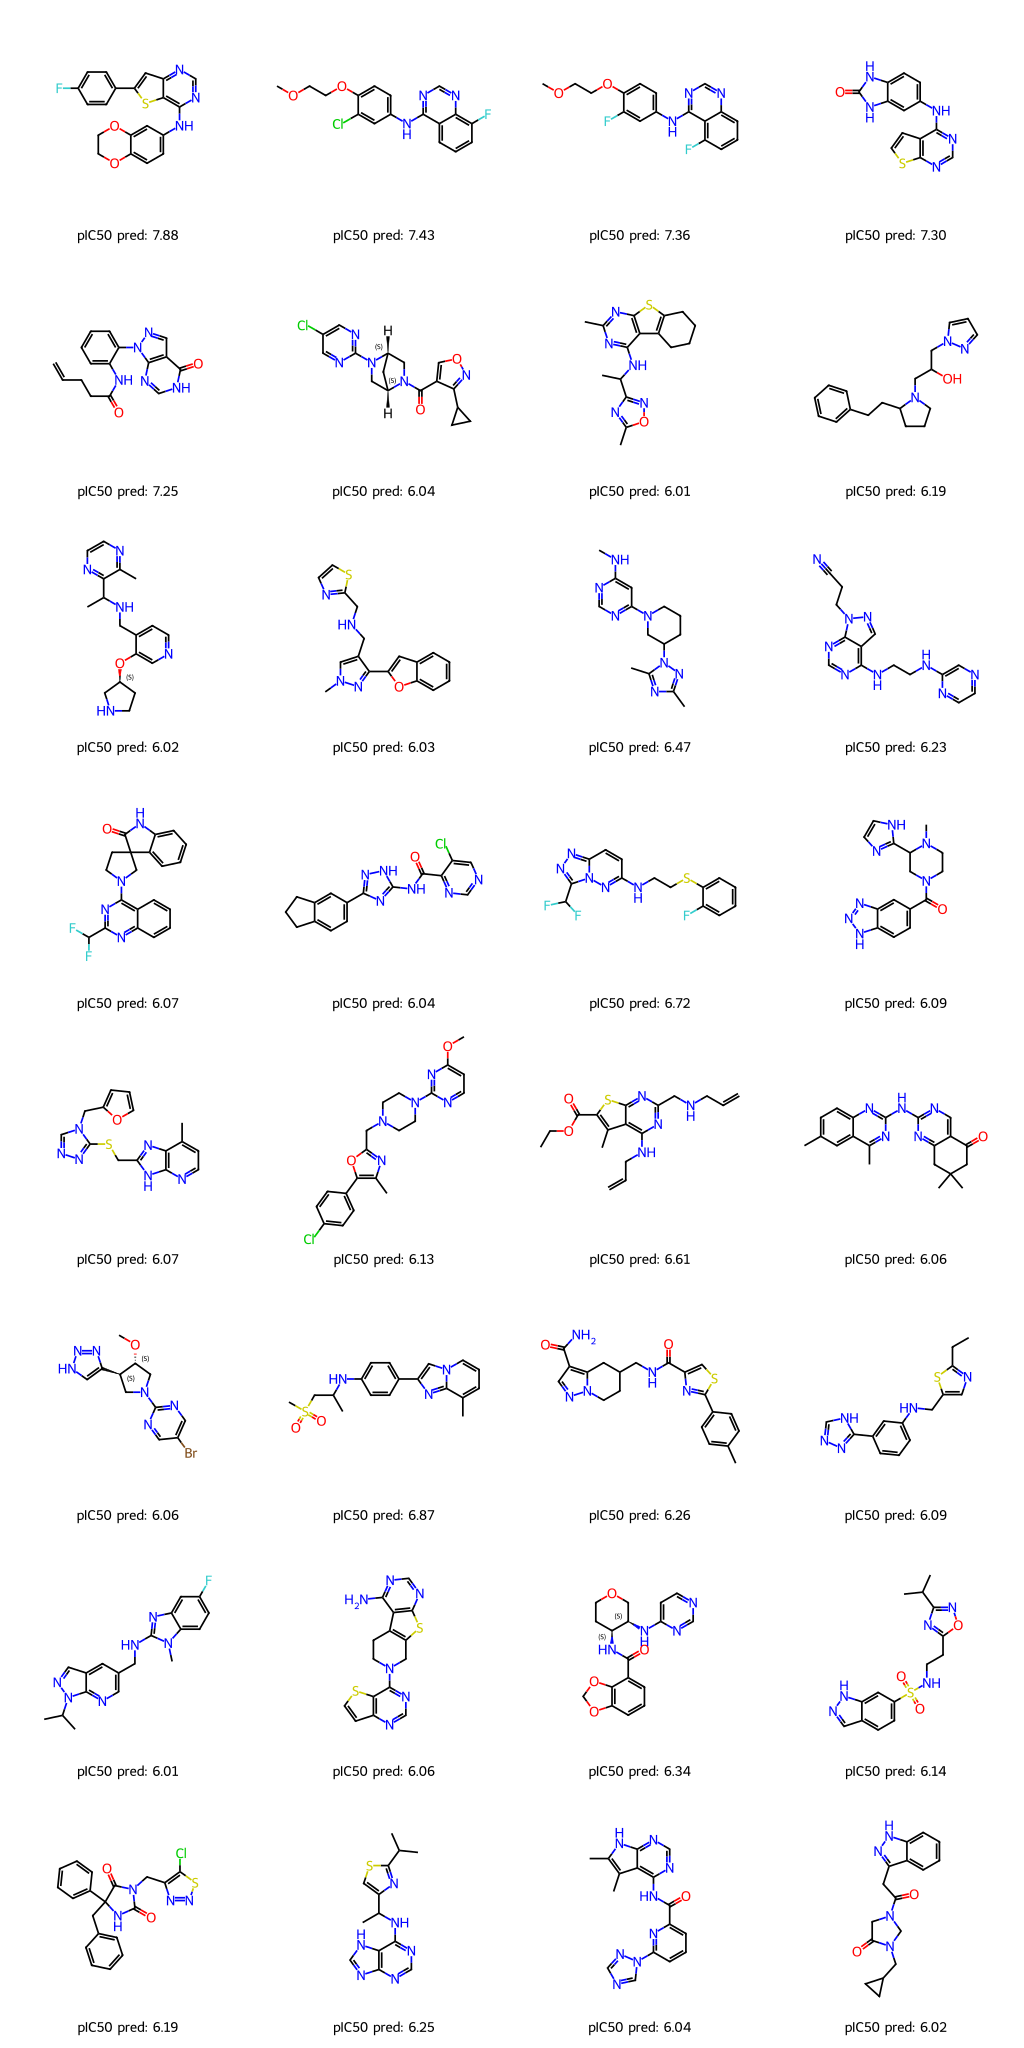

In [77]:
legends = lib_df_picked["rf_preds_pIC50"].apply(lambda x: 'pIC50 pred: {:,.2f}'.format(x)).tolist()
dm.to_image(lib_df_picked.mol.tolist(), legends=legends)


Our models could be used to rank the compounds and then further study those with the highest predicted binding affinity.


In [78]:
# Export the selected molecules
import os
os.makedirs("output", exist_ok=True)
lib_df_picked.drop(columns="mol").to_csv("output/picked100mols.csv", index=False)